In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [6]:
filename = '/home/havb/Dropbox/MSUI/Time Series and Spatial Statistics/data/AirPassengers.csv'
data=pd.read_csv(filename)

In [3]:
print data.head()
print '\n Data Types:'
print data.dtypes

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [9]:
#Convert the date field into a date type
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv(filename, parse_dates='Month', index_col='Month',date_parser=dateparse)
print data.head()
data.index

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=144, freq=None)

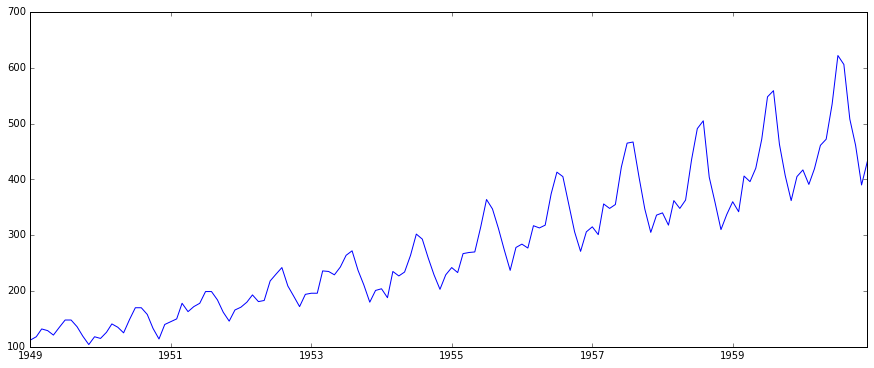

In [10]:
ts = data["#Passengers"]
#1. Specific the index as a string constant:
plt.plot(ts)

While one can visually observe trend in this data, this may be not be this non-trivial in most of the real life datasets. Hence, we do an Augmented Dickey Fuller test with null hypthesis that unit root is present in the time series(remember unit root from our guest lecture #1 and lectures on Random walk?).Hence, if p-value is less than 0.10, null hypthesis that unit root is present in the time-series is rejected. In present example, 0.10 is chosen as significance level. More details about this test can be read from here:

https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test.


### Let us determine the rolling statistics (moving averages) of mean and standard deviation with window size of 12.

Window size of 12 is selected by visual inspection of data as one can see the annual periodicity in the passanger timeseries. Function to perform ADF test on the timeseries is also below:



In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #%%
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

Let us run the function now. Since p-value of 0.99 is computed, one cannot reject the null hypothesis, HO : Presence of unit root in the time series.

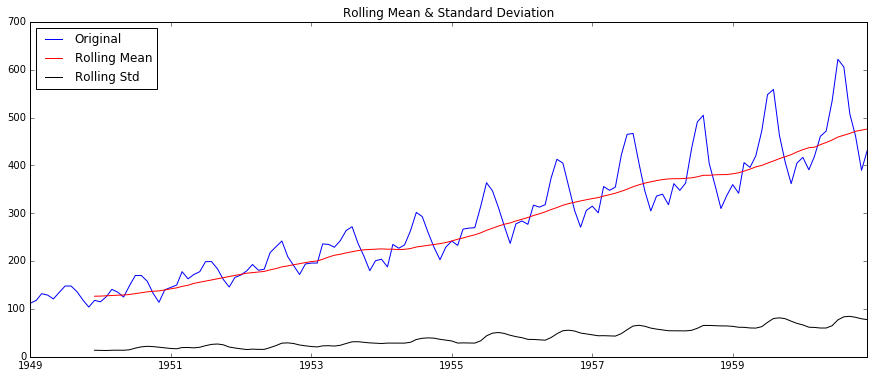

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
test_stationarity(ts)


## Making time-series Stationary

Though stationarity assumption is taken in many TS models, almost none of practical time series are stationary. So statisticians have figured out ways to make series stationary, which we’ll discuss now. Actually, its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:

1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

## Estimating & Eliminating Trend: Transformations

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:


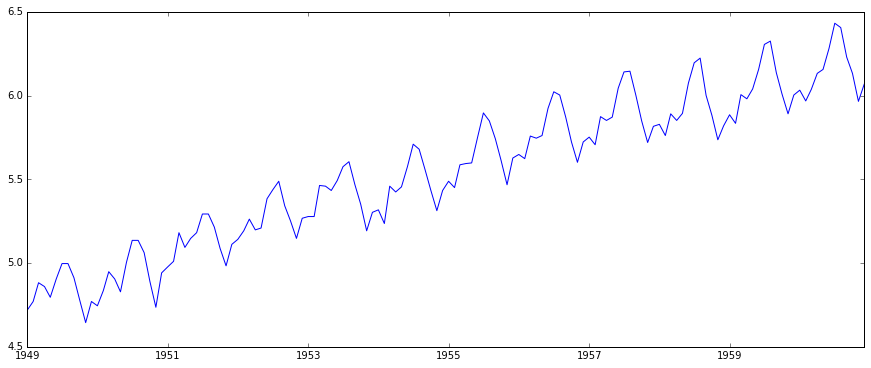

In [15]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Detrending

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

1. Aggregation – taking average for a time period like monthly/weekly averages
2. Smoothing – taking rolling averages
3. Polynomial Fitting – fit a regression model I will discuss smoothing here and you should try other techniques as well which might work out for other problems. Smoothing refers to taking rolling estimates, i.e. considering the past few instances. There are can be various ways but I will discuss two of those here.

## Moving average

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.


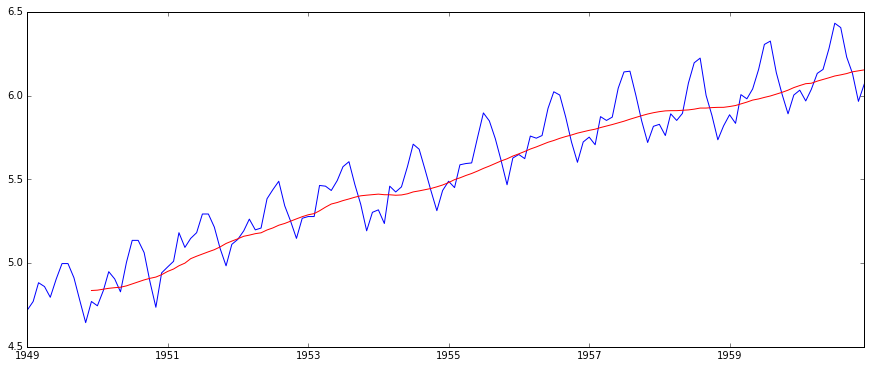

In [16]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [17]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

Notice the first 11 being Nan since we are differncing using a rolling window size of 12. Lets drop these NaN values and check the plots to test stationarity. Notice that p-value has decreased significantly in comparison to that of origianl time series after transforming and detrending, hence making the time-series stationary.

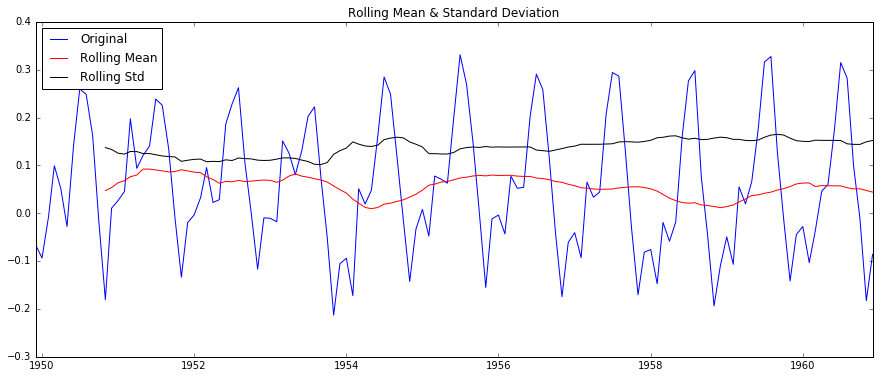

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [18]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

## Let us strive for better!

However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor This can be implemented in Pandas as:


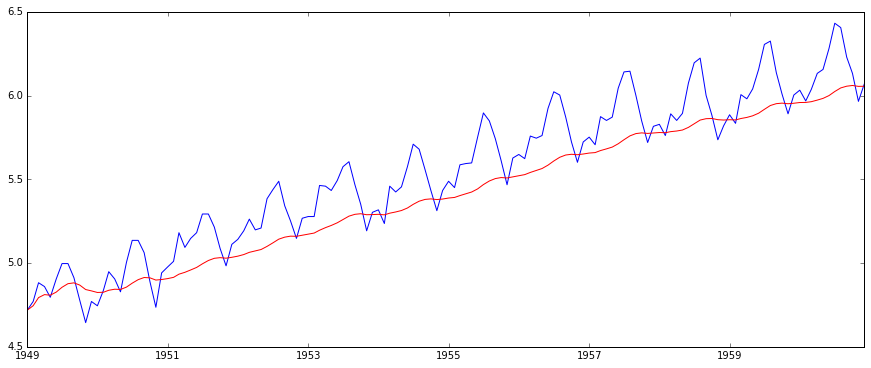

In [19]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

Note that with better method of detrending, p-value further got reduced:

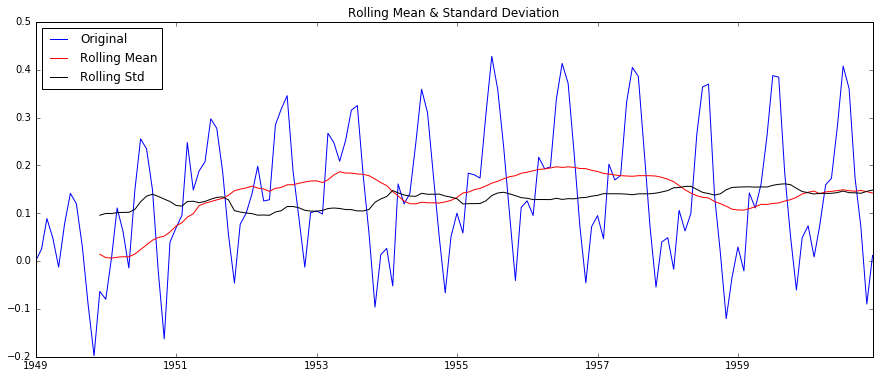

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)



This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

## Eliminating Trend and Seasonality by differencing

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

Differencing – taking the differece with a particular time lag Decomposition – modeling both trend and seasonality and removing them from the model. Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:


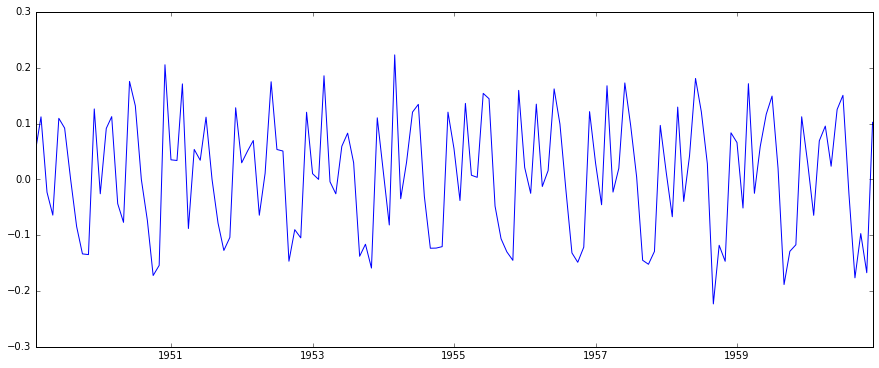

In [21]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)



This appears to have reduced trend and seasonality. Lets verify using p-values:


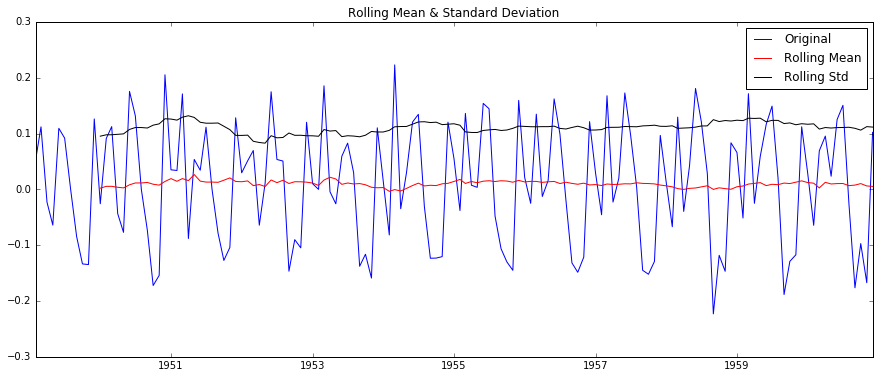

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [22]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)


## Using decompositions functions to remove, trends, seasons and residuals¶


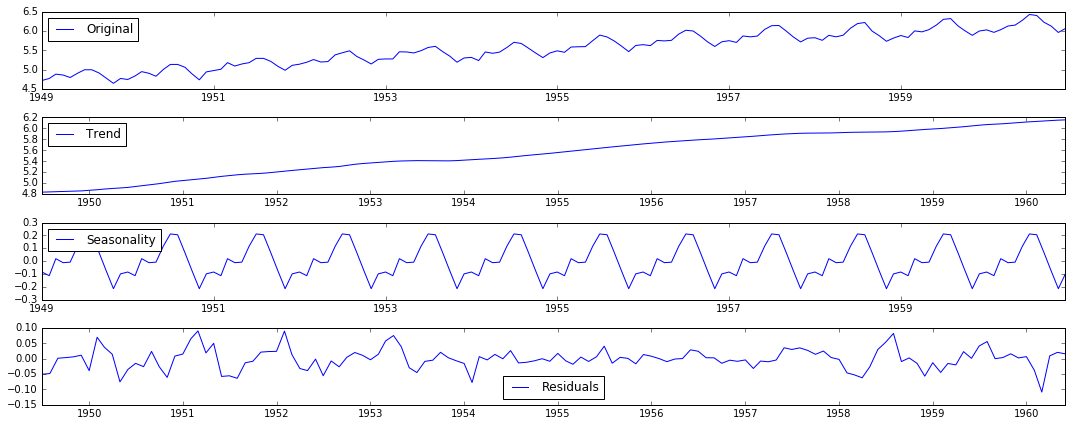

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

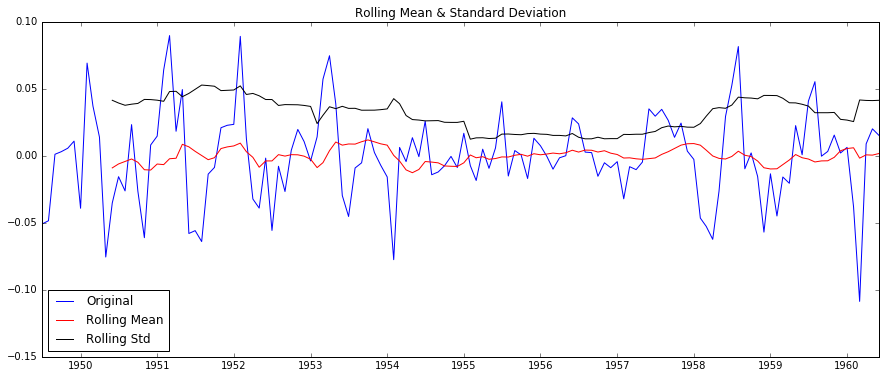

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (5%)           -2.885538e+00
Critical Value (1%)           -3.485122e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [24]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)



The Dickey-Fuller test statistic is significantly lower than the 0.10 critical value. So this TS is very close to stationary. You can try advanced decomposition techniques as well which can generate better results. Also, you should note that converting the residuals into original values for future data in not very intuitive in this case.

## Time-series forecasting

We saw different techniques and all of them worked reasonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare. A series with significant dependence among values. In this case we need to use some statistical models like AR processes/ ARIMA to forecast the data.

### ARIMA: Introduction

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model: Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5). Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results. An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

### ACF

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
PACF

###  Partial Autocorrelation Function (PACF): 

This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. PACF explained: Suppose you have 3 points in a time series x3 - x2 - x1. Using ACF you would generally find the correlation between x1 and x2 , for example. The value of correlation thus obtained is technically not true value of correlation, because the value of x2 is likely to be inspired by the value of x3. So PACF is that portion of the correlation between x1 and x2, which is not explained by the correlation between x3 in x2.


In [26]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

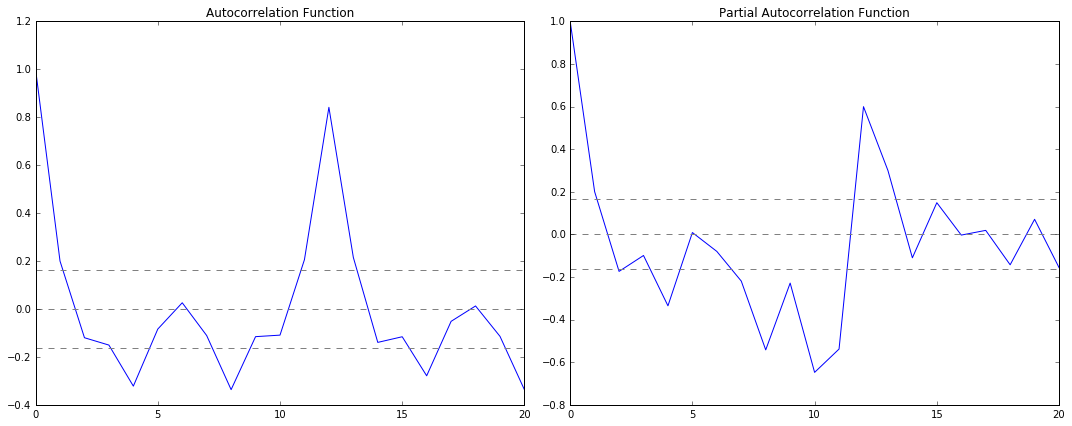

In [27]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()



In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2. Now, lets make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

## More about ARIMA

ARIMA models are, in theory, the most general class of models for forecasting a time series which can be made to be “stationary” by differencing (if necessary), perhaps in conjunction with nonlinear transformations such as logging or deflating (if necessary). A random variable that is a time series is stationary if its statistical properties are all constant over time. A stationary series has no trend, its variations around its mean have a constant amplitude, and it wiggles in a consistent fashion, i.e., its short-term random time patterns always look the same in a statistical sense. The latter condition means that its autocorrelations (correlations with its own prior deviations from the mean) remain constant over time, or equivalently, that its power spectrum remains constant over time. A random variable of this form can be viewed (as usual) as a combination of signal and noise, and the signal (if one is apparent) could be a pattern of fast or slow mean reversion, or sinusoidal oscillation, or rapid alternation in sign, and it could also have a seasonal component. An ARIMA model can be viewed as a “filter” that tries to separate the signal from the noise, and the signal is then extrapolated into the future to obtain forecasts.

The ARIMA forecasting equation for a stationary time series is a linear (i.e., regression-type) equation in which the predictors consist of lags of the dependent variable and/or lags of the forecast errors. That is:

Predicted value of Y = a constant and/or a weighted sum of one or more recent values of Y and/or a weighted sum of one or more recent values of the errors.

If the predictors consist only of lagged values of Y, it is a pure autoregressive (“self-regressed”) model, which is just a special case of a regression model and which could be fitted with standard regression software. For example, a first-order autoregressive (“AR(1)”) model for Y is a simple regression model in which the independent variable is just Y lagged by one period (LAG(Y,1) in Statgraphics or Y_LAG1 in RegressIt). If some of the predictors are lags of the errors, an ARIMA model it is NOT a linear regression model, because there is no way to specify “last period’s error” as an independent variable: the errors must be computed on a period-to-period basis when the model is fitted to the data. From a technical standpoint, the problem with using lagged errors as predictors is that the model’s predictions are not linear functions of the coefficients, even though they are linear functions of the past data. So, coefficients in ARIMA models that include lagged errors must be estimated by nonlinear optimization methods (“hill-climbing”) rather than by just solving a system of equations.

The acronym ARIMA stands for Auto-Regressive Integrated Moving Average. Lags of the stationarized series in the forecasting equation are called "autoregressive" terms, lags of the forecast errors are called "moving average" terms, and a time series which needs to be differenced to be made stationary is said to be an "integrated" version of a stationary series. Random-walk and random-trend models, autoregressive models, and exponential smoothing models are all special cases of ARIMA models.

A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where:

p is the number of autoregressive terms, d is the number of nonseasonal differences needed for stationarity, and q is the number of lagged forecast errors in the prediction equation.

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases. RSS stands for Residuals of Sum of Squares.

ARIMA (p,d,0) represents the AR(p) process with d order of differncing. Please note that d order differencing does not simply means that just differncing the values. Here is an example:

d=1 can be represented as:

$y' = Y_t - Y_{t - 1}$

d=2 can be written as:

$y'' = Y_t - Y_{t-1} - Y_{t-1} - Y_{t-2}$

and so on.

Let us begin with with AR(2) model on just logarithimically transformed dataset with d=1 differncing (equivalent to ARIMA (2,1,0) model. Please note that we are not using the differenced dataset because ARIMA processes with specified order of differencing will take care of detrending and removing the seasonality.

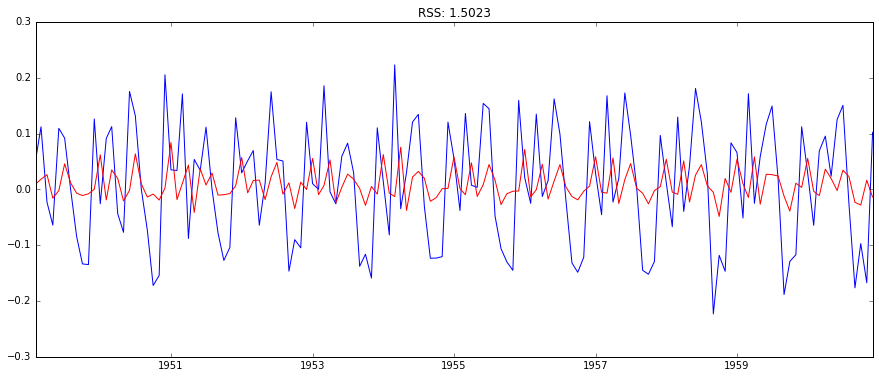

In [37]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Let us begin with with MA(2) model with d=1 differncing (equivalent to ARIMA (0,1,2) model:

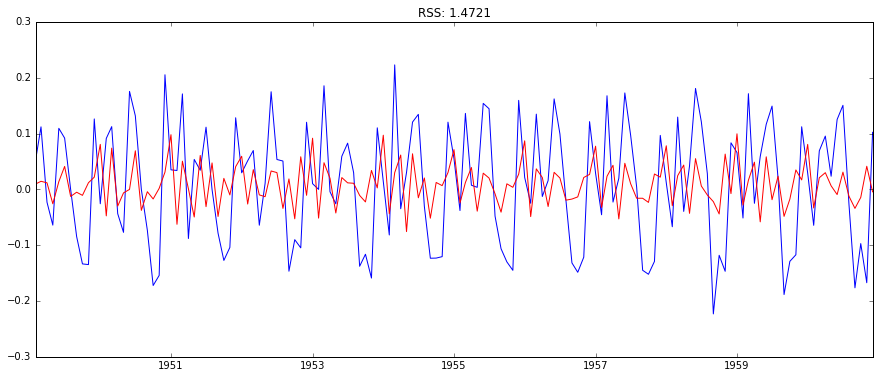

In [29]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

Let us try combined AR and MA model with one order of differencing:

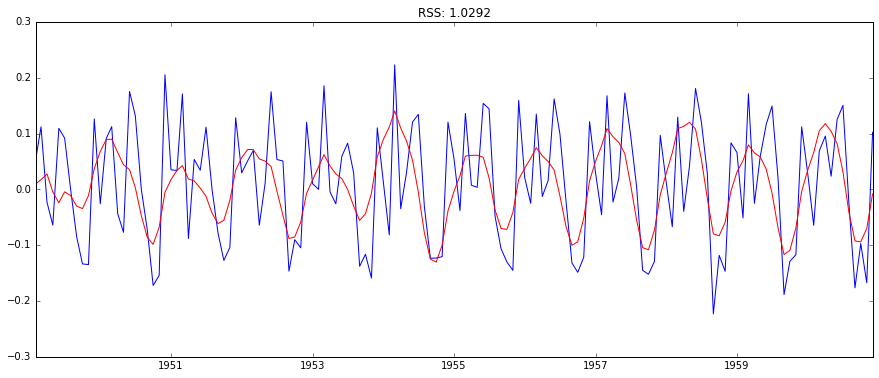

In [30]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))


# Finally the wait is over: Let us forecast

Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.


In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64




Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:



In [35]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64




You can quickly do some back of mind calculations using previous output to check if these are correct. Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:





In [34]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64


Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.


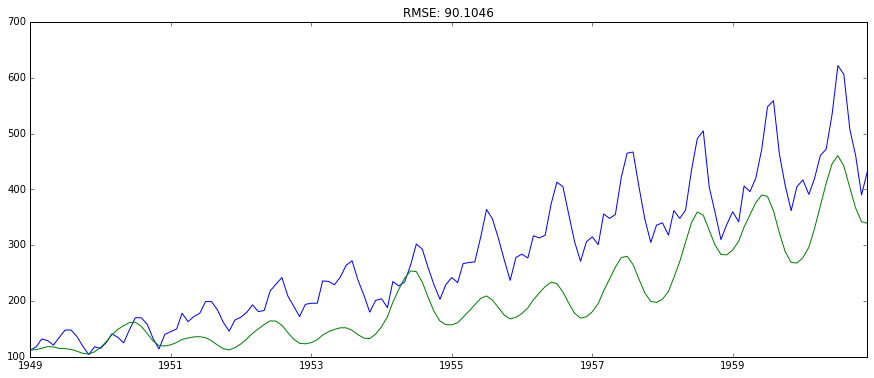

In [36]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))


References:

1. http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
2. https://onlinecourses.science.psu.edu/stat510/?q=book/export/html/50
3. https://www.otexts.org/fpp/8/1
4. http://people.duke.edu/~rnau/411arim.htm

